In [1]:
import importlib
import DSP
importlib.reload(DSP)
import Regression
importlib.reload(Regression)

<module 'Regression' from '/Users/rohankotwani/Documents/Complex-Time-Series-Signal-Processing/Regression.py'>

In [2]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd

In [3]:
full=pd.read_csv("DATA/DSC_Time_Series_Challenge.csv",dtype = {'Day ':str,'Sessions':int,'Pageviews':int})
full['time']=[datetime.datetime.strptime(t[0],"%m/%d/%y") for t in full[['Day ']].values]
full=full.sort_values(by=['time'])
full['index']=DSP.datetime_index(full['time'])


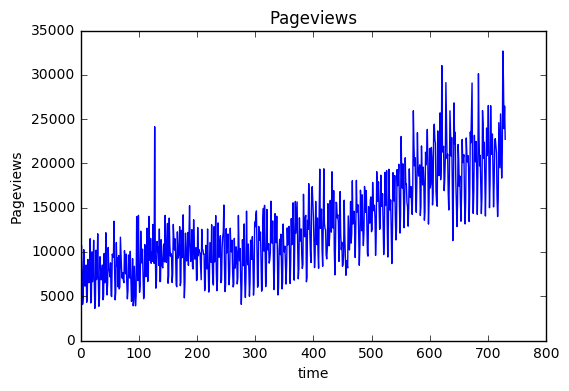

In [4]:
train=full[:500].copy()
valid=full[500:].copy()
train.head(n=5)

plt.plot(full['index'],full['Pageviews'],'-')
plt.xlabel('time')
plt.ylabel('Pageviews')
plt.title('Pageviews')
plt.show()

### Differenced time series

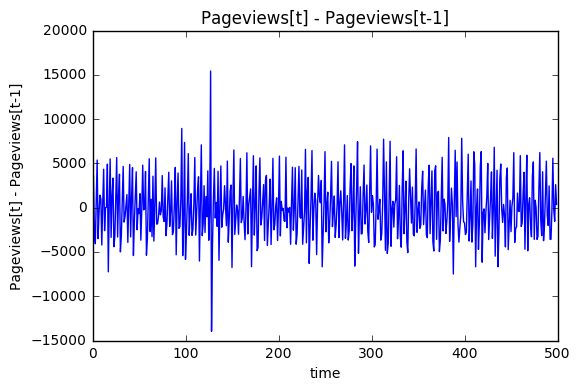

In [5]:
time_diff_signal = DSP.time_diff_variable(train['Pageviews'],1)
plt.plot(train['index'][1:],time_diff_signal,'-');plt.xlabel('time');plt.ylabel('Pageviews[t] - Pageviews[t-1]');plt.title('Pageviews[t] - Pageviews[t-1]')
plt.show()

### FFT transformation

/Users/rohankotwani/anaconda/envs/datasci/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


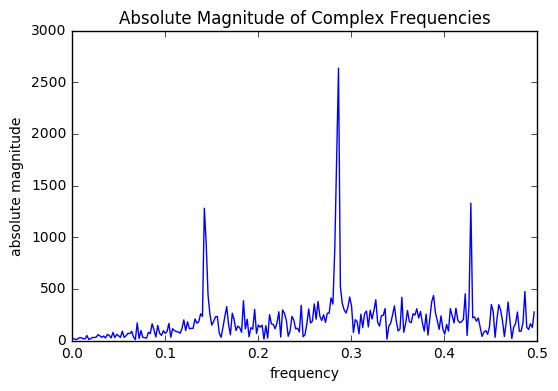

In [6]:
N = len(time_diff_signal)
unfiltered  = DSP.get_frequency_domain(time_diff_signal)
f,y  = unfiltered[:,0],unfiltered[:,1]
y_abs=( 2.0/N * np.abs(y[1:]))
plt.plot(f[1:],y_abs);plt.xlabel('frequency');plt.ylabel('absolute magnitude');plt.title("Absolute Magnitude of Complex Frequencies")
plt.show()

### Filtering frequency domain: center, band, and threshold

In [7]:
abs_filtered = np.absolute(DSP.filter_freq_domain(unfiltered, center=0.3,band=0.2,threshold=500))
print("Frequency, Magnitude")
print(abs_filtered)

period_list = set([round(1/(ft)) for ft,ht in abs_filtered if round(1/(ft))>2])
print("periods: ",period_list)

Frequency, Magnitude
[[  1.42284569e-01   3.19255651e+05]
 [  1.44288577e-01   2.34548226e+05]
 [  2.82565130e-01   2.21374826e+05]
 [  2.84569138e-01   4.33991133e+05]
 [  2.86573146e-01   6.57663768e+05]
 [  2.88577154e-01   1.29892004e+05]
 [  4.28857715e-01   3.31444427e+05]]
periods:  {3.0, 4.0, 7.0}


### Trend component T(t) : Polynomial regression

R-squared:  -0.292495451555


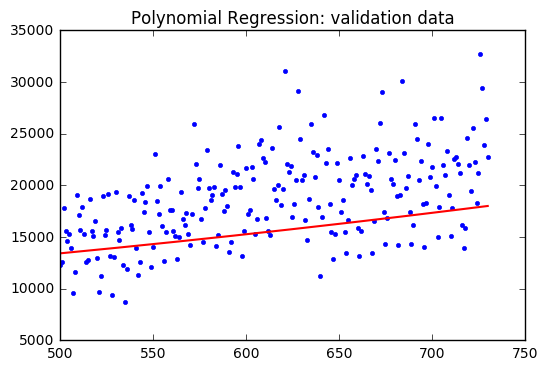

In [8]:
heap = []
for i in range(1,15):
    z=Regression.sklearn_poly_regression(train[['index']],train[['Pageviews']],i)
    SSE = Regression.numpy_poly_regression_SSE(valid[['index']],valid[['Pageviews']],i,z)
    heap.append((SSE,i))

power = int(Regression.heapsort(heap)[0][1])

T_train = Regression.pandas_poly_feature(train[['index']],power).values
T_valid = Regression.pandas_poly_feature(valid[['index']],power).values

z = Regression.numpy_simple_regression(T_train,train[['Pageviews']].values)
predict = Regression.numpy_predict(T_valid,z)
SSE = Regression.numpy_SSE(T_valid,valid[['Pageviews']],z)
SST = np.sum((valid['Pageviews']-np.mean(valid['Pageviews']))**2)

print("R-squared: ",1-SSE/SST)
plt.plot(valid['index'],valid['Pageviews'],'b.');plt.plot(valid['index'],predict,'r-',linewidth=1.5);plt.title("Polynomial Regression: validation data")
plt.show()

### Seasonal Component S(t) : Waveform generation

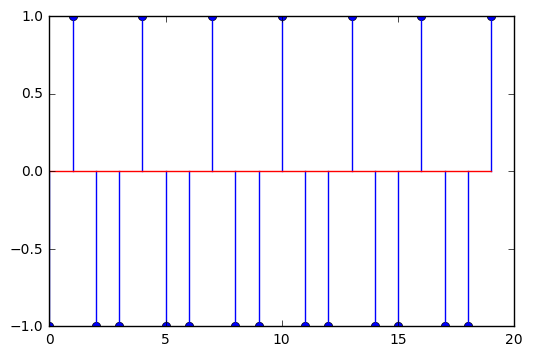

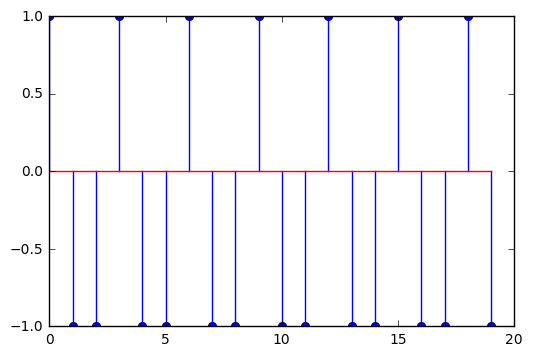

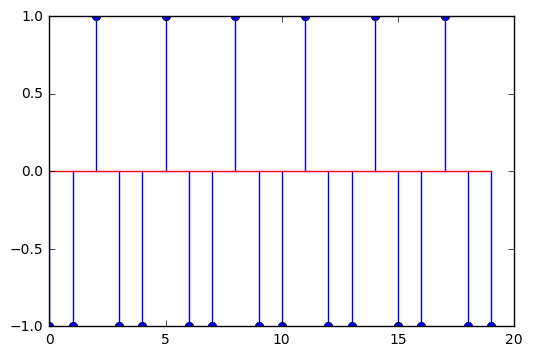

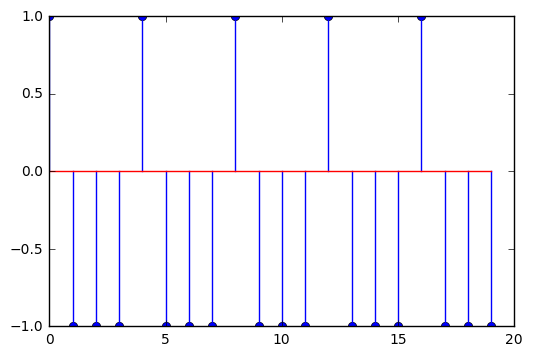

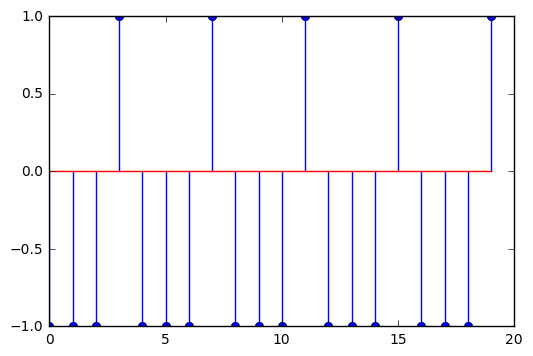

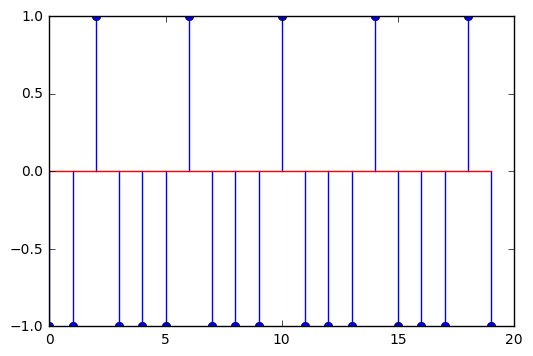

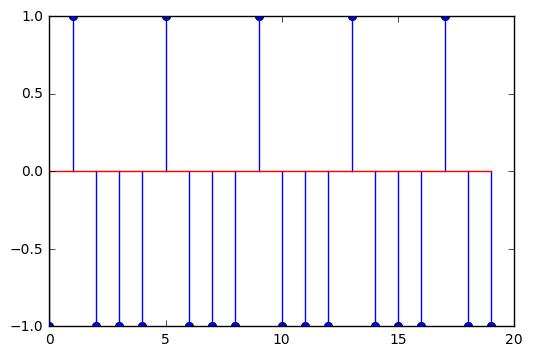

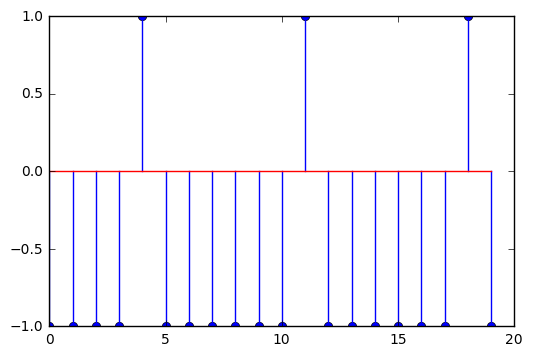

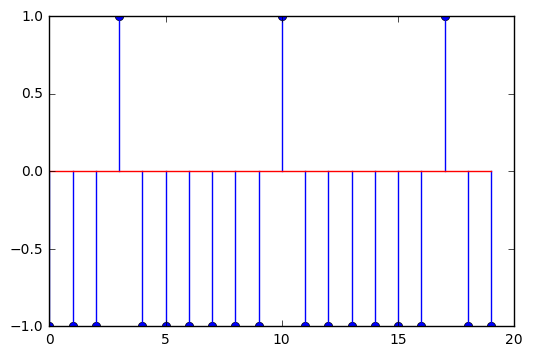

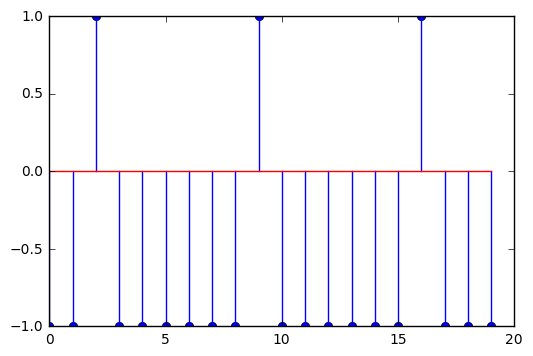

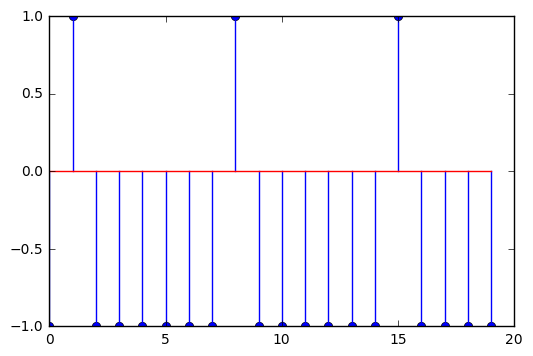

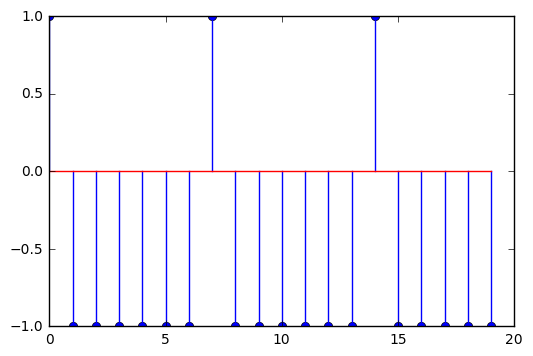

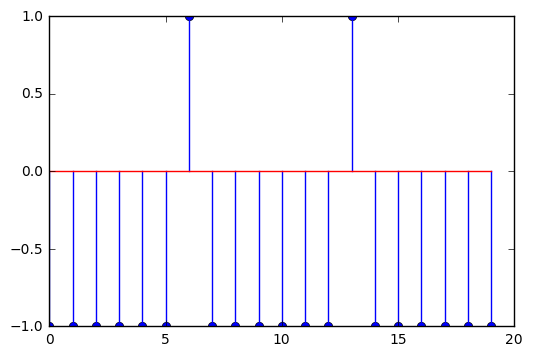

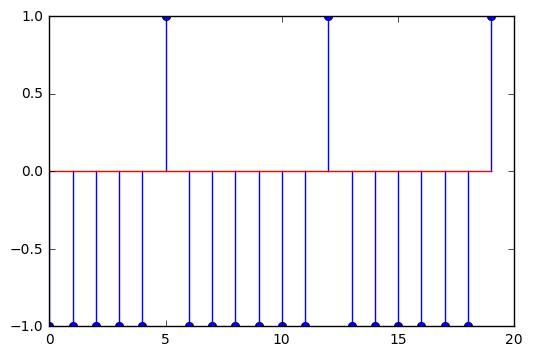

In [9]:
import importlib
import DSP
importlib.reload(DSP)
S_train = np.ones((len(train),1))
S_valid = np.ones((len(valid),1))
 
for period in period_list:
    x = DSP.generate_square_waves(train['index'],period)
    S_train=np.column_stack((S_train,x))

    x = DSP.generate_square_waves(valid['index'],period)
    S_valid=np.column_stack((S_valid,x))
    
    for i in range(x.shape[1]):
        plt.stem(x[:20,i])
        plt.show()

S_train,S_valid = S_train[:,1:],S_valid[:,1:]

### Trend & Seasonal Regression with LASSO feature selection: x(t) = T(t) + S(t) +R(t) + error

In [10]:
heap = []
for i in range(1,15):
    T_train = Regression.pandas_poly_feature(train[['index']],i).values
    T_valid = Regression.pandas_poly_feature(valid[['index']],i).values

    
    for thresh in np.linspace(50,600,10):
        abs_filtered = np.absolute(DSP.filter_freq_domain(unfiltered, center=0.25,band=0.25,threshold=thresh))

        period_list = set([round(1/(ft)) for ft,ht in abs_filtered if round(1/(ft))>2])
#                 print(period_list)

        S_train = np.ones((len(train),1))
        S_valid = np.ones((len(valid),1))
        for period in period_list:

            x = DSP.generate_square_waves(train['index'],period)
            S_train=np.column_stack((S_train,x))
        
            x = DSP.generate_square_waves(valid['index'],period)
            S_valid=np.column_stack((S_valid,x))

        S_train,S_valid = S_train[:,1:],S_valid[:,1:]

        P_train_df = pd.DataFrame(np.column_stack((S_train,T_train)))
        P_valid_df = pd.DataFrame(np.column_stack((S_valid,T_valid)))
        
        lasso_heap=[]
        for l1_penalty in np.logspace(1, 7, num=13):
            z = Regression.sklearn_lasso_regression(P_train_df,train[['Pageviews']],l1_penalty)
            SSE = Regression.numpy_SSE(P_valid_df,valid[['Pageviews']],z)
            lasso_heap.append((SSE,l1_penalty))
        penalty = Regression.heapsort(lasso_heap)[0][1]
        mask = Regression.sklearn_lasso_feature_selection(P_train_df,train[['Pageviews']],penalty)

        z = Regression.numpy_simple_regression(P_train_df[mask].values,train[['Pageviews']])
        SSE = Regression.numpy_SSE(P_valid_df[mask].values,valid[['Pageviews']],z)
        heap.append((SSE,i,thresh,penalty))

In [11]:
SSE,i,thresh,penalty = Regression.heapsort(heap)[0]
print("model paramters: ",i,thresh,penalty)

model paramters:  4 111.111111111 10.0


R-squared:  0.595640967344


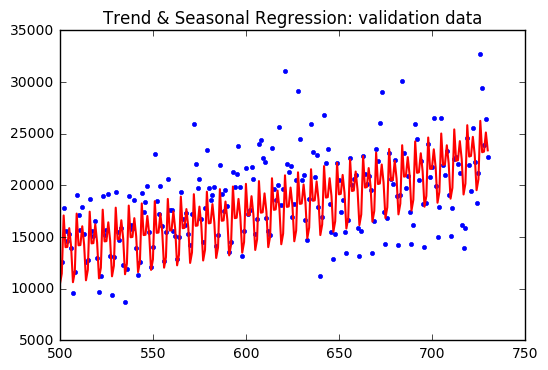

In [12]:
T_train = Regression.pandas_poly_feature(train[['index']],i).values
T_valid = Regression.pandas_poly_feature(valid[['index']],i).values
abs_filtered = np.absolute(DSP.filter_freq_domain(unfiltered, center=0.25,band=0.25,threshold=thresh))

period_list = set([round(1/(ft)) for ft,ht in abs_filtered if round(1/(ft))>2])

S_train = np.ones((len(train),1))
S_valid = np.ones((len(valid),1))
for period in period_list:

        x = DSP.generate_square_waves(train['index'],period)
        S_train=np.column_stack((S_train,x))
        
        x = DSP.generate_square_waves(valid['index'],period)
        S_valid=np.column_stack((S_valid,x))

S_train,S_valid = S_train[:,1:],S_valid[:,1:]
P_train = np.column_stack((S_train,T_train))
P_valid = np.column_stack((S_valid,T_valid))
P_train_df = pd.DataFrame(P_train)
P_valid_df = pd.DataFrame(P_valid)

mask = Regression.sklearn_lasso_feature_selection(P_train_df,train[['Pageviews']],penalty)
z = Regression.numpy_simple_regression(P_train_df[mask].values,train[['Pageviews']])

SSE = Regression.numpy_SSE(P_valid_df[mask].values,valid[['Pageviews']],z)
SST = np.sum((valid['Pageviews']-np.mean(valid['Pageviews']))**2)
predict = Regression.numpy_predict(P_valid_df[mask].values,z)

print("R-squared: ",1-SSE/SST)
plt.plot(valid['index'],valid['Pageviews'],'b.');plt.plot(valid['index'],predict,'r-',linewidth=1.5);plt.title("Trend & Seasonal Regression: validation data")
plt.show()




In [13]:
z

array([[  7.19310865e+03],
       [  1.54815172e+03],
       [ -1.25118203e+03],
       [ -1.74547641e+03],
       [  8.94583161e+02],
       [  8.12621520e+00],
       [  3.42197552e-08]])

### Statsmodels autocorrelation

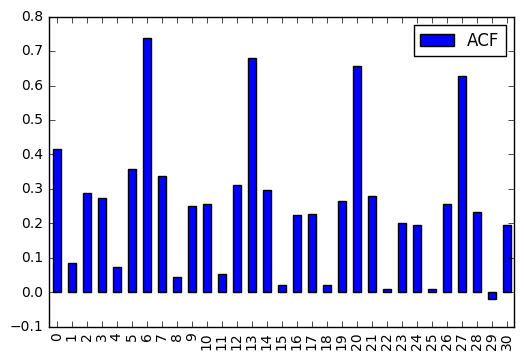

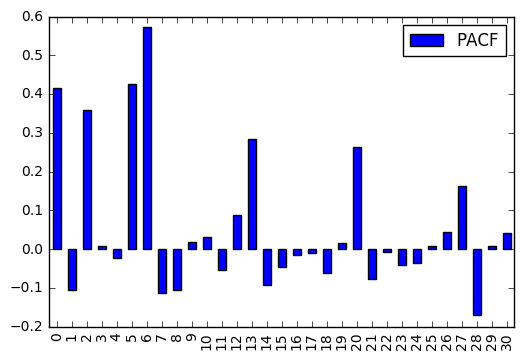

In [14]:
import statsmodels
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

full=pd.read_csv("DATA/DSC_Time_Series_Challenge.csv",dtype = {'Day ':str,'Sessions':int,'Pageviews':int})
time=[datetime.datetime.strptime(t[0],"%m/%d/%y") for t in full[['Day ']].values]
full['time']=time
full['Pageviews']=full['Pageviews'].apply(float)

series = full.set_index('time')['Pageviews']
train=series[:500].copy()
valid=series[500:].copy()

ticker_data_acf_1 =  acf(train)[1:32]
test_df = pd.DataFrame([ticker_data_acf_1]).T
test_df.columns = ['ACF']
test_df.plot(kind='bar')
plt.show()

ticker_data_pacf_1 =  pacf(train)[1:32]
test_df = pd.DataFrame([ticker_data_pacf_1]).T
test_df.columns = ['PACF']
test_df.plot(kind='bar')
plt.show()

### Statsmodels ARIMA model - choose p, d, and q parameters

In [15]:
%%capture --no-stdout
heap = []
import time
for p in range(0,10):
    for d in range(0,3):
        for q in range(1,10):
            model = statsmodels.tsa.arima_model.ARIMA(train, order=(p,d,q))
            try:
                model_fit = model.fit(disp=0)
                residuals = pd.DataFrame(model_fit.resid)
                predictions = model_fit.forecast(len(valid))
                SSE = np.sum((valid.values - predictions[0])**2)
                heap.append((SSE,p,d,q))
            except:
                time.sleep(0.01)
                pass



In [16]:
SSE,p,d,q = Regression.heapsort(heap)[0]

R-squared:  0.362854882183


/Users/rohankotwani/anaconda/envs/datasci/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


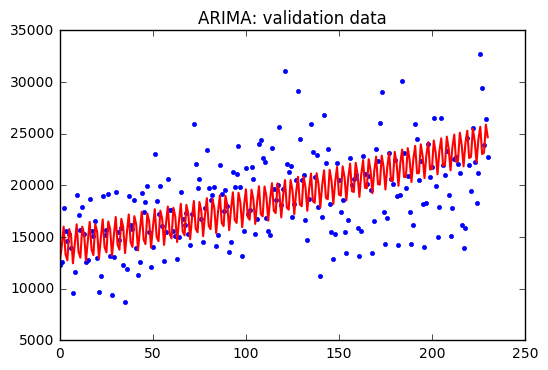

In [17]:
model = statsmodels.tsa.arima_model.ARIMA(train, order=(p,d,q))
model_fit = model.fit(disp=0)
residuals = pd.DataFrame(model_fit.resid)
predictions = model_fit.forecast(len(valid))
SSE = np.sum((valid.values - predictions[0])**2)
print("R-squared: ",1-SSE/SST)
plt.plot(valid.values,'b.');plt.plot(predictions[0],'r-',linewidth=1.5);plt.title("ARIMA: validation data")
plt.show()